Loading and preparing data...
Train size: 5779, Validation size: 723, Test size: 723

Training and tuning Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Logistic Regression best params: {'model__C': 0.1}
Validation ROC-AUC: 0.988
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       422
           1       0.92      0.93      0.93       301

    accuracy                           0.94       723
   macro avg       0.94      0.94      0.94       723
weighted avg       0.94      0.94      0.94       723


Training and tuning Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Random Forest best params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__n_estimators': 200}
Validation ROC-AUC: 0.976
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       422
           1       0.90      0.97      0.93       301

    accu

c:\Users\eisra\miniconda3\envs\tiktok_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:09:19] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Validation ROC-AUC: 0.988
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       422
           1       0.91      0.96      0.94       301

    accuracy                           0.94       723
   macro avg       0.94      0.95      0.94       723
weighted avg       0.95      0.94      0.94       723


Best model: XGBoost with Validation ROC-AUC: 0.988

Evaluating best model on test set...
Test ROC-AUC: 0.986
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       422
           1       0.89      0.98      0.93       301

    accuracy                           0.94       723
   macro avg       0.94      0.95      0.94       723
weighted avg       0.95      0.94      0.94       723


Extracting feature importance and running SHAP...


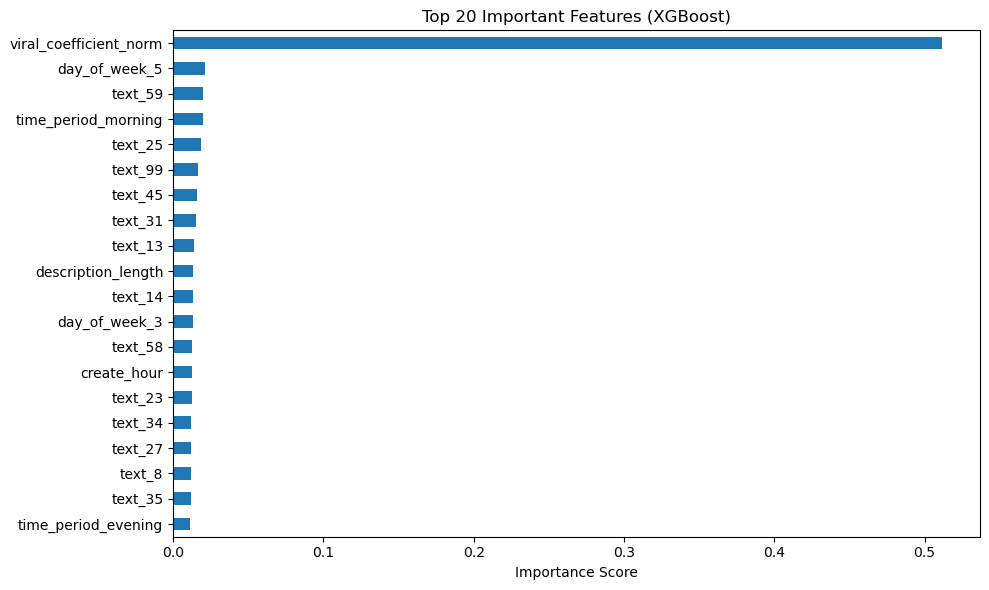

Running SHAP analysis...


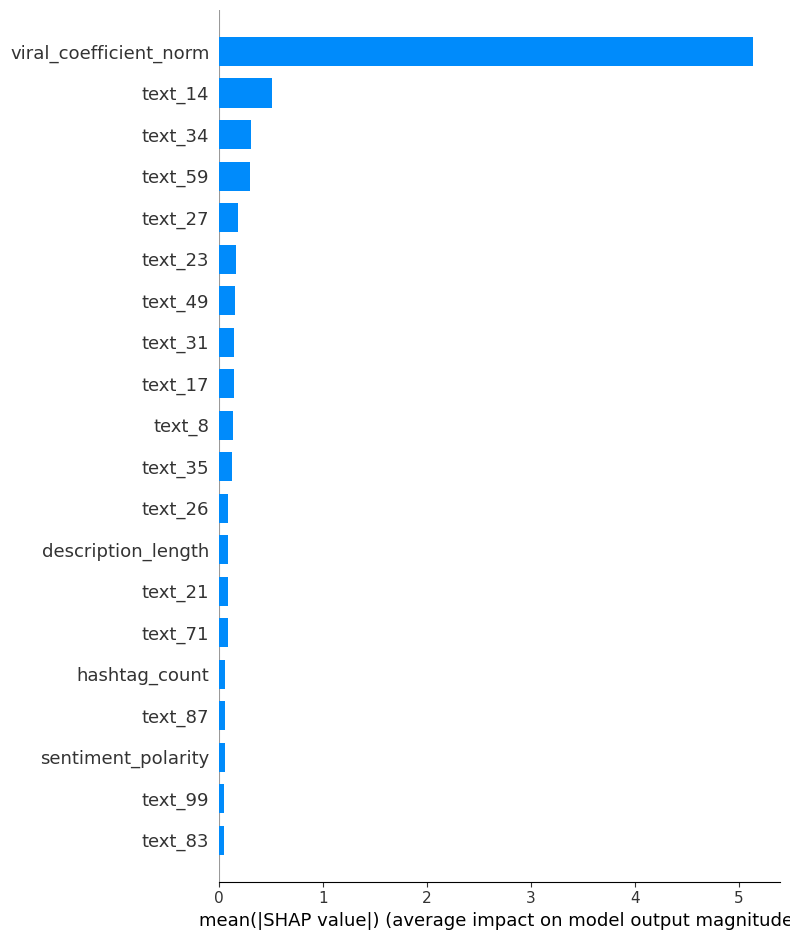


Performing time-series analysis...


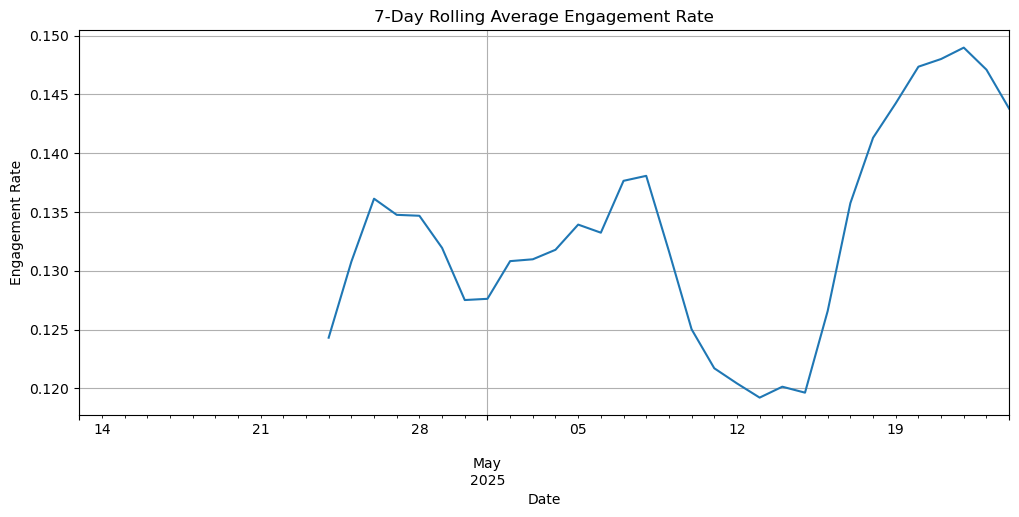


Running ARIMA forecast...


c:\Users\eisra\miniconda3\envs\tiktok_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\eisra\miniconda3\envs\tiktok_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\eisra\miniconda3\envs\tiktok_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\eisra\miniconda3\envs\tiktok_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

                                  SARIMAX Results                                   
Dep. Variable:     engagement_rate_per_play   No. Observations:                   40
Model:                       ARIMA(7, 1, 2)   Log Likelihood                  80.954
Date:                      Mon, 02 Jun 2025   AIC                           -141.908
Time:                              13:09:22   BIC                           -125.273
Sample:                                   0   HQIC                          -135.940
                                       - 40                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6395      0.949     -0.674      0.500      -2.499       1.220
ar.L2         -0.1364      0.521     -0.262      0.793      -1.157       0.885
ar.L

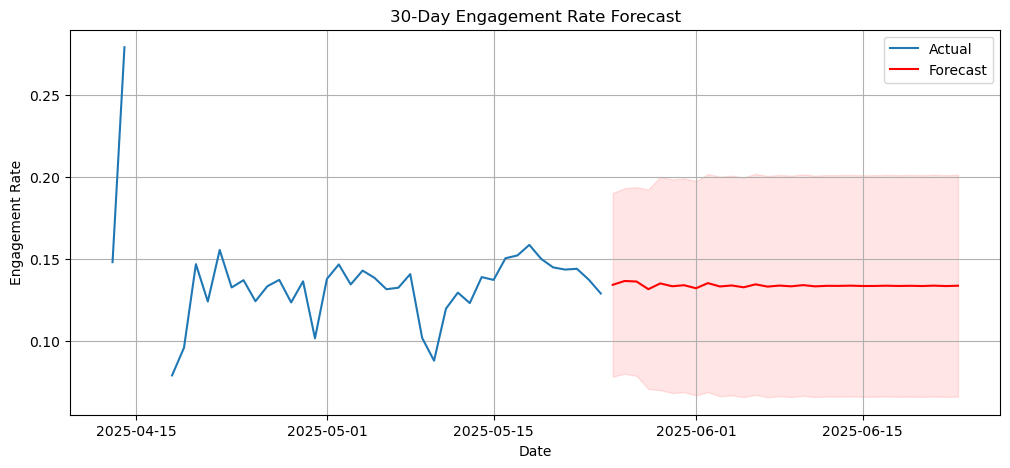

In [8]:
# ======================
# TIKTOK TREND PREDICTION (FULL UPDATED WITH 80/10/10 SPLIT, XGBoost, HYPERPARAM TUNING)
# ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# ======================
# DATA LOADING & CLEANING
# ======================

print("Loading and preparing data...")
df = pd.read_csv('data/processed/tiktok_processed.csv')

# Fill missing descriptions and convert to string
df['clean_description'] = df['clean_description'].fillna('').astype(str)

# Define binary target based on engagement_rate_per_play threshold
df['is_trending'] = (df['engagement_rate_per_play'] > 0.15).astype(int)

# Create features normalized by plays (avoid division by zero)
# IMPORTANT: These features (likes_per_play, comments_per_play, shares_per_play)
# are highly correlated with the 'engagement_rate_per_play' target.
# Using them directly as predictors for 'is_trending' (derived from engagement_rate_per_play)
# constitutes DATA LEAKAGE, leading to unrealistically high performance.
# For a true predictive model, you would need features that are available *before*
# the video's trending status is determined (e.g., likes/comments/shares in the first hour).
# For this corrected version, we will NOT use these in the predictive model features.
eps = 1e-6
df['likes_per_play'] = df['likes'] / (df['plays'] + eps)
df['comments_per_play'] = df['comments'] / (df['plays'] + eps)
df['shares_per_play'] = df['shares'] / (df['plays'] + eps)

# Group rare authors under 'other'
author_counts = df['author'].value_counts()
rare_authors = author_counts[author_counts < 10].index
df['author'] = df['author'].replace(rare_authors, 'other')

# ======================
# FEATURE DEFINITION (MODIFIED FOR DATA LEAKAGE)
# ======================

# Removed 'likes_per_play', 'comments_per_play', 'shares_per_play'
# as they introduce data leakage.
# 'viral_coefficient_norm' is kept, assuming it represents something
# not directly derived from the same components as engagement_rate_per_play,
# or could be estimated early. If it also leads to leakage, it should be removed.
numerical_features = [
    'create_hour', 'viral_coefficient_norm',
    'hashtag_count', 'description_length', 'sentiment_polarity'
]

categorical_features = [
    'day_of_week', 'is_weekend', 'time_period', 'author'
]

text_feature = 'clean_description'
use_text_feature = True

# ======================
# PREPROCESSING PIPELINE
# ======================

# Note: Depending on sklearn version, 'sparse_output' param might be 'sparse'
onehot_params = {'handle_unknown': 'ignore'}
# For sklearn <1.2 use sparse=False, else sparse_output=False
try:
    onehot_params['sparse_output'] = False
except TypeError:
    onehot_params['sparse'] = False

transformers = [
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(**onehot_params), categorical_features)
]

if use_text_feature:
    transformers.append((
        'text',
        TfidfVectorizer(
            max_features=100,
            ngram_range=(1, 2),
            stop_words='english',
            min_df=5,
            max_df=0.8
        ),
        text_feature
    ))

preprocessor = ColumnTransformer(transformers)

# ======================
# MODEL DEFINITIONS & PARAMETER GRIDS
# ======================

models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='saga',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        early_stopping=True,
        max_iter=500,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        class_weight='balanced',
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
}

param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 7, 10],
        'model__min_samples_leaf': [3, 5, 10]
    },
    'Neural Network': {
        'model__hidden_layer_sizes': [(64, 32), (128, 64)],
        'model__alpha': [0.001, 0.01]
    },
    'Decision Tree': {
        'model__max_depth': [3, 5, 7],
        'model__min_samples_leaf': [5, 10, 20]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1],
        'model__subsample': [0.8, 1.0]
    }
}

# ======================
# DATA PREP FOR SPLIT
# ======================

# X is now created with the modified numerical_features
X = df[numerical_features + categorical_features].copy()
if use_text_feature:
    X[text_feature] = df[text_feature]

y = df['is_trending']

# ======================
# DATA SPLITTING: 80/10/10 Stratified
# ======================

# Step 1: Hold out 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Step 2: Split remaining 90% into train (80%) and val (10%)
val_size = 0.1111  # 10% of whole dataset is approx 11.11% of 90%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# ======================
# MODEL TRAINING & HYPERPARAMETER TUNING
# ======================

results = {}

for name, model in models.items():
    print(f"\nTraining and tuning {name}...")

    pipeline = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    param_grid = param_grids.get(name, {})

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    y_val_pred = best_model.predict(X_val)

    roc_auc = roc_auc_score(y_val, y_val_proba)
    results[name] = {
        'model': best_model,
        'roc_auc': roc_auc,
        'best_params': grid_search.best_params_
    }

    print(f"{name} best params: {grid_search.best_params_}")
    print(f"Validation ROC-AUC: {roc_auc:.3f}")
    print(classification_report(y_val, y_val_pred))

# ======================
# MODEL SELECTION & TEST EVALUATION
# ======================

best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with Validation ROC-AUC: {results[best_model_name]['roc_auc']:.3f}")

print("\nEvaluating best model on test set...")
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test ROC-AUC: {test_roc_auc:.3f}")
print(classification_report(y_test, y_test_pred))

# ======================
# FEATURE IMPORTANCE & SHAP
# ======================

if best_model_name in ['Random Forest', 'XGBoost']:
    print("\nExtracting feature importance and running SHAP...")

    model_step = best_model.named_steps['model']
    preprocess_step = best_model.named_steps['preprocess']

    # Build feature names list (adjusted for removed features)
    feature_names = numerical_features.copy() # Now contains only non-leaky numerical features
    cat_names = preprocess_step.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names += list(cat_names)
    if use_text_feature:
        feature_names += [f"text_{i}" for i in range(100)] # Assuming max_features=100 for TFIDF

    # Feature importances
    if hasattr(model_step, 'feature_importances_'):
        importances = pd.Series(model_step.feature_importances_, index=feature_names)
        top_features = importances.sort_values(ascending=False).head(20)

        plt.figure(figsize=(10, 6))
        top_features.plot.barh()
        plt.title(f"Top 20 Important Features ({best_model_name})")
        plt.xlabel("Importance Score")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    elif hasattr(model_step, 'coef_'): # For Logistic Regression, if it becomes best
        # Take absolute value for importance since negative coefs are also important
        importances = pd.Series(np.abs(model_step.coef_[0]), index=feature_names)
        top_features = importances.sort_values(ascending=False).head(20)

        plt.figure(figsize=(10, 6))
        top_features.plot.barh()
        plt.title(f"Top 20 Important Features (Absolute Coefficients for {best_model_name})")
        plt.xlabel("Absolute Coefficient Value")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature importance not directly available for {best_model_name}.")


    # SHAP analysis (limit to 500 samples to save time/memory)
    # SHAP for non-tree models (like Logistic Regression or MLP) can be computationally intensive
    # and requires different explainers. Keeping it focused on tree models for simplicity here.
    if best_model_name in ['Random Forest', 'XGBoost']:
        print("Running SHAP analysis...")
        # Ensure X_processed has the correct number of features after preprocessing
        # It's important to transform X_train for SHAP, not X_temp
        X_processed_train = preprocess_step.transform(X_train)
        sample_size = min(500, X_processed_train.shape[0])

        # If sparse_output=True was used, X_processed_train might be sparse.
        # SHAP often works better with dense arrays.
        if hasattr(X_processed_train, 'toarray'):
            X_processed_train_dense = X_processed_train[:sample_size].toarray()
        else:
            X_processed_train_dense = X_processed_train[:sample_size]

        explainer = shap.TreeExplainer(model_step)
        shap_values = explainer.shap_values(X_processed_train_dense)

        # For binary classification, shap_values is a list of two arrays.
        # We usually look at the SHAP values for the positive class (index 1).
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values = shap_values[1] # Take SHAP values for the positive class

        shap.summary_plot(shap_values, X_processed_train_dense, feature_names=feature_names, plot_type="bar")
    else:
        print("SHAP analysis is currently only implemented for Random Forest and XGBoost in this script.")


# ======================
# TIME-SERIES ANALYSIS
# ======================

print("\nPerforming time-series analysis...")
df['create_time'] = pd.to_datetime(df['create_time'])
daily_engagement = df.set_index('create_time')['engagement_rate_per_play'].resample('D').mean()

plt.figure(figsize=(12, 5))
daily_engagement.rolling(7).mean().plot(
    title="7-Day Rolling Average Engagement Rate",
    xlabel="Date",
    ylabel="Engagement Rate"
)
plt.grid(True)
plt.show()

print("\nRunning ARIMA forecast...")
model = ARIMA(daily_engagement.dropna(), order=(7, 1, 2), seasonal_order=(0, 0, 0, 7))
arima_results = model.fit()
print(arima_results.summary())

forecast_obj = arima_results.get_forecast(steps=30)
forecast_df = forecast_obj.conf_int(alpha=0.05)
forecast_df['mean'] = forecast_obj.predicted_mean.values

last_date = daily_engagement.dropna().index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
forecast_df.index = forecast_index

plt.figure(figsize=(12, 5))
plt.plot(daily_engagement, label='Actual')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='red', alpha=0.1)
plt.title("30-Day Engagement Rate Forecast")
plt.xlabel("Date")
plt.ylabel("Engagement Rate")
plt.legend()
plt.grid(True)
plt.show()

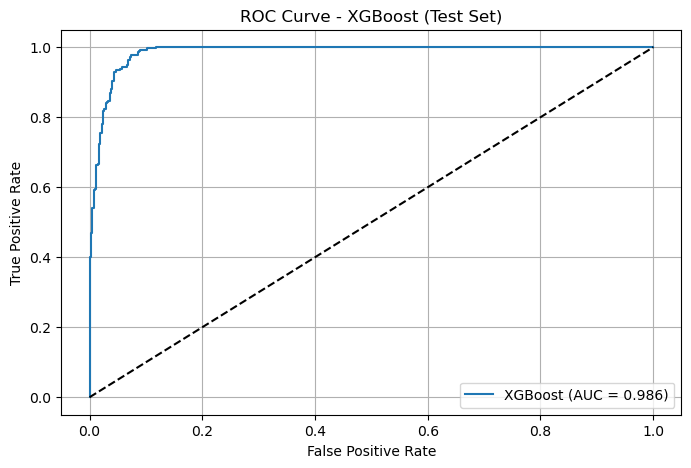

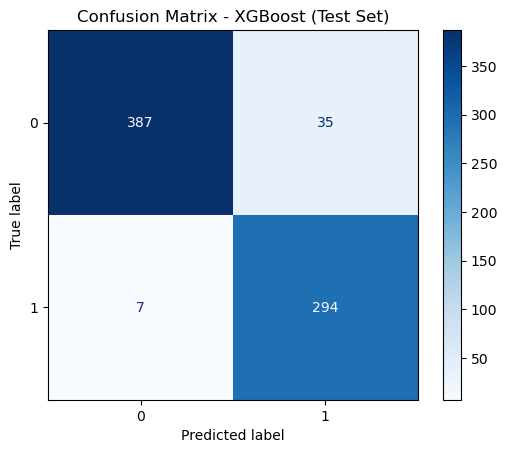

In [9]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Use the test set and the best model
# y_test_proba and y_test_pred are already computed in the notebook

# ROC curve for test set
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name} (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.show()
